Subtask B: Verifiable factual claims detection: Given a tweet, predict whether it contains a verifiable factual claim. This is a binary task with two labels: Yes and No. This is a classification task

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import spacy

import warnings
warnings.filterwarnings("ignore")

# Load Lemmatizer
nlp = spacy.load("en_core_web_sm")

# Load Stopwords
nltk.download('stopwords')
cachedStopWords = list(set(stopwords.words("english")))



# a)
# Twitter Datasets
df_worthy_train = pd.read_csv("data/1b/CT22_english_1B_claim_train.tsv", sep='\t')
df_worthy_test = pd.read_csv("data/1b/CT22_english_1B_claim_dev_test.tsv", sep='\t')

# Top 3000 most commonly used english words + covid related medical terms (used as vocabulary for the vectorization process)
topwords = pd.read_csv('words.txt', sep=" ", header=None).values[:,0]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\minh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Handling of imbalanced data

In [2]:
df_worthy_train["class_label"].value_counts()

1    2122
0    1202
Name: class_label, dtype: int64

In [3]:
df_true = df_worthy_train[df_worthy_train["class_label"] == 1]
df_true.shape

(2122, 5)

In [4]:
df_false = df_worthy_train[df_worthy_train["class_label"] == 0]
df_false.shape

(1202, 5)

In [5]:
df_true_downsampled = df_true.sample(df_false.shape[0])
df_true_downsampled.shape

(1202, 5)

In [6]:
# downsampled
df_balanced_d = pd.concat([df_true_downsampled, df_false])
df_balanced_d.shape

(2404, 5)

In [7]:
df_false_upsampled = df_false.sample(df_true.shape[0], replace=True)
df_false_upsampled.shape

(2122, 5)

In [8]:
# upsampled
df_balanced_u = pd.concat([df_true, df_false_upsampled])
df_balanced_u.shape

(4244, 5)

In [9]:
mean_val = (df_false.shape[0] + df_true.shape[0])/2
df_true_mv = df_true.sample(int(mean_val))
df_false_mv = df_false.sample(int(mean_val), replace=True)

In [10]:
# Hybrid
df_balanced_h = pd.concat([df_true_mv, df_false_mv])
df_balanced_h.shape

(3324, 5)

### Emoji Removal

In [11]:
# Function to remove emojies when using the lemmatizer
#https://poopcode.com/how-to-remove-emoji-from-text-in-python/
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

### Custom Tokenizer

In [12]:
def tokenize_text(text, method="stopwords"):
    
    # Remove hyperlinks
    text = re.sub(r'http\S+', '', text)
    
    # Split sentence into words
    tokens = []
    for token in ngrams(text.split(), 1):
        word = re.sub(r',', '', token[0]) #Remove commas
        word = re.sub(r'[\!\.\:]$', '', word) #Remove (.!:) at the end of tokens
        word = re.sub(r'#', '', word) #Remove hashtags (not the text)
        if word == "—": continue #Ignore dash
        if word.find("@") != -1: continue #Ignore tags
        tokens.append(word)
    tokens

    # List comprehension to remove stopwords
    if method != "default":
        tokens = [x for x in tokens if x not in cachedStopWords]

    # Perform stemming
    if method == "stemming":
        ps = PorterStemmer()
        tokens = [ps.stem(x) for x in tokens]

    # Perform lemmatization
    if method == "lemmatizer":
        # Remove emojies due to lemmatizer not handling them well
        tokens = [x for x in tokens if remove_emoji(x) == x]
        text = " ".join(tokens)
        doc = nlp(text)
        tokens = [token.lemma_ for token in doc]

    return tokens

In [13]:
def tokenize_normal(text):
    return tokenize_text(text, method="default")

def tokenize_stopwords(text):
    return tokenize_text(text, method="stopwords")

def tokenize_stemming(text):
    return tokenize_text(text, method="stemming")

def tokenize_lemmatizer(text):
    return tokenize_text(text, method="lemmatizer")

In [14]:
def tokenize_df(df, text_col, method="default"):
    article_tokens = []
    for i in range(len(df)):
        text = df.iloc[i][text_col].lower()
        article_tokens.append(tokenize_text(text, method))
    df["tokens"] = article_tokens

In [15]:
tokenize_df(df_balanced_d, "tweet_text", "lemmatizer")
tokenize_df(df_balanced_u, "tweet_text", "lemmatizer")
tokenize_df(df_balanced_h, "tweet_text", "lemmatizer")
tokenize_df(df_worthy_train, "tweet_text", "lemmatizer")
tokenize_df(df_worthy_test, "tweet_text", "lemmatizer")

In [16]:
print(df_balanced_d.iloc[0]["tokens"], "\n")
print(df_balanced_u.iloc[0]["tokens"], "\n")
print(df_balanced_h.iloc[0]["tokens"], "\n")
print(df_worthy_train.iloc[0]["tokens"], "\n")
print(df_worthy_test.iloc[0]["tokens"])

['multilingual', 'resource', 'available', 'city', 'cambridge', 'website', 'resident', 'read', 'download', 'important', 'information', 'covid-19', 'testing', 'vaccine', 'food', 'housing', 'resource', 'city', 'service', '7', 'different', 'language', '-', 'cambma'] 

['india', "'s", 'gift', '100000', 'covid-19', 'vaccine', 'arrive', 'barbado', 'early', 'today', 'special', 'moment', 'barbadian', 'want', 'thank', 'prime', 'minister', 'modi', 'quick', 'decisive', 'magnanimous', 'action', 'allow', 'we', 'beneficiary', 'vaccine'] 

['last', 'september', 'common', 'folk', 'clearly', 'see', 'state', 'emergency', 'anymore', 'vaccine', 'therapeutic', 'empty', 'hospital', 'decline', 'case', '&', 'amp', ';', 'deaths', '&', 'amp', ';', 'natural', 'immunity', 'wtf', 'go', 'on', '-', 'dewine', 'want', 'lose', 'power', 'get'] 

['india', "'s", 'gift', '100000', 'covid-19', 'vaccine', 'arrive', 'barbado', 'early', 'today', 'special', 'moment', 'barbadian', 'want', 'thank', 'prime', 'minister', 'modi', 'q

### Bag of words

In [17]:
from sklearn.feature_extraction.text import CountVectorizer # For creating a DTM (discrete values)
from sklearn.feature_extraction.text import TfidfVectorizer # A weighted DTM (fractions)

cv_dict = {}
tfidf_dict = {}
ngram_list = [1,2,3]
for n in ngram_list:
    cv_dict[n] = CountVectorizer(tokenizer=tokenize_lemmatizer, ngram_range=(n, n), max_features=5000)
    tfidf_dict[n] = TfidfVectorizer(tokenizer=tokenize_stopwords, ngram_range=(n, n), max_features=5000)
#cv = CountVectorizer(tokenizer=tokenize_lemmatizer, ngram_range=(1, 1), max_features=5000) #Test with different n-grams, min_df, max_df and max_features
#tfidf = TfidfVectorizer(tokenizer=tokenize_stopwords, ngram_range=(1, 1), max_features=5000) #Test with (1,1), (2,2), and (3,3) 

In [18]:
tweet_vec = {}
tweet_bow_train = {}
tweet_bow_test = {}

tweet_vec_d = {}
tweet_bow_train_d = {}
tweet_bow_test_d = {}

tweet_vec_u = {}
tweet_bow_train_u = {}
tweet_bow_test_u = {}

tweet_vec_h = {}
tweet_bow_train_h = {}
tweet_bow_test_h = {}
for n in ngram_list:
    tweet_vec[n] = cv_dict[n].fit(df_worthy_train["tweet_text"]) # DTM (CV, but normalized for relative frequency)
    tweet_bow_train[n] = tweet_vec[n].transform(df_worthy_train["tweet_text"]) 
    tweet_bow_test[n] = tweet_vec[n].transform(df_worthy_test["tweet_text"]) 
    
    # balanced downsample
    tweet_vec_d[n] = cv_dict[n].fit(df_balanced_d["tweet_text"]) # DTM (CV, but normalized for relative frequency)
    tweet_bow_train_d[n] = tweet_vec_d[n].transform(df_balanced_d["tweet_text"]) 
    tweet_bow_test_d[n] = tweet_vec_d[n].transform(df_worthy_test["tweet_text"]) 
    
    # balanced upsample
    tweet_vec_u[n] = cv_dict[n].fit(df_balanced_u["tweet_text"]) # DTM (CV, but normalized for relative frequency)
    tweet_bow_train_u[n] = tweet_vec_u[n].transform(df_balanced_u["tweet_text"]) 
    tweet_bow_test_u[n] = tweet_vec_u[n].transform(df_worthy_test["tweet_text"]) 
    
    # balanced hybridsample
    tweet_vec_h[n] = cv_dict[n].fit(df_balanced_h["tweet_text"]) # DTM (CV, but normalized for relative frequency)
    tweet_bow_train_h[n] = tweet_vec_h[n].transform(df_balanced_h["tweet_text"]) 
    tweet_bow_test_h[n] = tweet_vec_h[n].transform(df_worthy_test["tweet_text"]) 

### Feature Exploration

In [19]:
# If max_features not limited, there are 8263 unique words (features) and a total of 51333 words across 2123 tweets
for n in ngram_list:
    captured = tweet_bow_train[n].sum()
    print(f"Total words across all tweets: 51333")
    print(f"Total words captured by our features/vocabulary {captured} ({round(100*captured/51333, 1)}%)")
    print(f"Amount of unique words (tokens/features): {len(tweet_vec[n].vocabulary_)}\n") # Unique words (features)

    # vec.vocabulary_items() => Dict with every word in the vocabulary with the DTM column index as the value
    sum_words = tweet_bow_train[n].sum(axis=0) # Sum the columns from the DTM matrix
    words_freq = [(word, sum_words[0, index]) for word, index in tweet_vec[n].vocabulary_.items()] # Make a list pairing every word with its corresponding DTM column summation
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    print("Most frequent terms for {}-gram: \n {}".format(n, words_freq[:10])) # show top n terms used

Total words across all tweets: 51333
Total words captured by our features/vocabulary 67277 (131.1%)
Amount of unique words (tokens/features): 5000

Most frequent terms for 1-gram: 
 [('vaxxers', 3853), ('ct', 2047), ('-', 962), ('"', 590), ('givehope', 558), ('cry', 491), ('p', 404), ('ctv', 371), ('aarp', 351), ('werenâ\x80\x99t', 348)]
Total words across all tweets: 51333
Total words captured by our features/vocabulary 22939 (44.7%)
Amount of unique words (tokens/features): 5000

Most frequent terms for 2-gram: 
 [('covid-19 outbreak', 1250), ('% (', 294), ('? least', 294), ('coronovirus covid19', 247), ('covid-19 unvaccinated', 140), ('covid-19 pandemic', 104), ('- chat', 100), ('safe majority', 89), ('community educate', 79), ('health care', 72)]
Total words across all tweets: 51333
Total words captured by our features/vocabulary 9921 (19.3%)
Amount of unique words (tokens/features): 5000

Most frequent terms for 3-gram: 
 [("' make india", 294), ('covid-19 relief package', 56), ('

### Dummy Predictions

In [20]:
from sklearn.dummy import DummyClassifier
from sklearn import metrics

for n in ngram_list:
    print("--------Unbalanced--------")
    dummy_clf = DummyClassifier(strategy="prior")
    dummy_clf.fit(tweet_bow_train[n], df_worthy_train["class_label"])
    print("{}-gram Priors: {}".format(n, dummy_clf.class_prior_))

    accuracy_score = metrics.accuracy_score(dummy_clf.predict(tweet_bow_test[n]), df_worthy_test["class_label"])
    print("Dummy Accuracy for {}-gram: {}%".format(n, round(accuracy_score * 100, 2)))

    f1_score = metrics.f1_score(dummy_clf.predict(tweet_bow_test[n]), df_worthy_test["class_label"])
    print("Dummy F1-Score for {}-gram: {}%".format(n, round(f1_score * 100, 2)))
    
    # Downsampled
    print("--------Downsampled--------")
    dummy_clf_d = DummyClassifier(strategy="prior")
    dummy_clf_d.fit(tweet_bow_train_d[n], df_balanced_d["class_label"])
    print("{}-gram Priors: {}".format(n, dummy_clf_d.class_prior_))

    accuracy_score = metrics.accuracy_score(dummy_clf_d.predict(tweet_bow_test_d[n]), df_worthy_test["class_label"])
    print("Dummy Accuracy for {}-gram: {}%".format(n, round(accuracy_score * 100, 2)))

    f1_score = metrics.f1_score(dummy_clf_d.predict(tweet_bow_test_d[n]), df_worthy_test["class_label"])
    print("Dummy F1-Score for {}-gram: {}%".format(n, round(f1_score * 100, 2)))
    
    # Upsampled
    print("--------Upsampled--------")
    dummy_clf_u = DummyClassifier(strategy="prior")
    dummy_clf_u.fit(tweet_bow_train_u[n], df_balanced_u["class_label"])
    print("{}-gram Priors: {}".format(n, dummy_clf_u.class_prior_))

    accuracy_score = metrics.accuracy_score(dummy_clf_u.predict(tweet_bow_test_u[n]), df_worthy_test["class_label"])
    print("Dummy Accuracy for {}-gram: {}%".format(n, round(accuracy_score * 100, 2)))

    f1_score = metrics.f1_score(dummy_clf_u.predict(tweet_bow_test_u[n]), df_worthy_test["class_label"])
    print("Dummy F1-Score for {}-gram: {}%".format(n, round(f1_score * 100, 2)))
    
    # Hybridsampled
    print("--------Hybridsampled--------")
    dummy_clf_h = DummyClassifier(strategy="prior")
    dummy_clf_h.fit(tweet_bow_train_h[n], df_balanced_h["class_label"])
    print("{}-gram Priors: {}".format(n, dummy_clf_h.class_prior_))

    accuracy_score = metrics.accuracy_score(dummy_clf_h.predict(tweet_bow_test_h[n]), df_worthy_test["class_label"])
    print("Dummy Accuracy for {}-gram: {}%".format(n, round(accuracy_score * 100, 2)))

    f1_score = metrics.f1_score(dummy_clf_h.predict(tweet_bow_test_h[n]), df_worthy_test["class_label"])
    print("Dummy F1-Score for {}-gram: {}%".format(n, round(f1_score * 100, 2)))
    print("--------------------------------------")

--------Unbalanced--------
1-gram Priors: [0.36161252 0.63838748]
Dummy Accuracy for 1-gram: 63.01%
Dummy F1-Score for 1-gram: 77.31%
--------Downsampled--------
1-gram Priors: [0.5 0.5]
Dummy Accuracy for 1-gram: 36.99%
Dummy F1-Score for 1-gram: 0.0%
--------Upsampled--------
1-gram Priors: [0.5 0.5]
Dummy Accuracy for 1-gram: 36.99%
Dummy F1-Score for 1-gram: 0.0%
--------Hybridsampled--------
1-gram Priors: [0.5 0.5]
Dummy Accuracy for 1-gram: 36.99%
Dummy F1-Score for 1-gram: 0.0%
--------------------------------------
--------Unbalanced--------
2-gram Priors: [0.36161252 0.63838748]
Dummy Accuracy for 2-gram: 63.01%
Dummy F1-Score for 2-gram: 77.31%
--------Downsampled--------
2-gram Priors: [0.5 0.5]
Dummy Accuracy for 2-gram: 36.99%
Dummy F1-Score for 2-gram: 0.0%
--------Upsampled--------
2-gram Priors: [0.5 0.5]
Dummy Accuracy for 2-gram: 36.99%
Dummy F1-Score for 2-gram: 0.0%
--------Hybridsampled--------
2-gram Priors: [0.5 0.5]
Dummy Accuracy for 2-gram: 36.99%
Dummy F1-Sc

### Naive Bayes Prediction

In [21]:
#https://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes
from sklearn.naive_bayes import MultinomialNB # suited for classification with discrete features
from sklearn.naive_bayes import ComplementNB # suited for imbalanced datasets (designed to correct for "severe assumptions")
from sklearn.naive_bayes import BernoulliNB # designed for classification with binary/boolean features
from sklearn.naive_bayes import GaussianNB # designed for classification with continuous values

clf_nb = ComplementNB()  # Unbalanced
clf_d = MultinomialNB()   # Balanced
clf_u = MultinomialNB() 
clf_h = MultinomialNB() 
for n in ngram_list:
    print("--------Unbalanced--------")
    clf_nb.fit(tweet_bow_train[n].toarray(), df_worthy_train["class_label"])

    accuracy_score = metrics.accuracy_score(clf_nb.predict(tweet_bow_test[n].toarray()), df_worthy_test["class_label"])
    print("Complement Accuracy for {}-gram: {}%".format(n, round(accuracy_score * 100, 2)))

    f1_score = metrics.f1_score(clf_nb.predict(tweet_bow_test[n].toarray()), df_worthy_test["class_label"])
    print("Complement F1-Score for {}-gram: {}%".format(n, round(f1_score * 100, 2)))
    
    # Balanced
    print("--------Downsampled--------")
    clf_d.fit(tweet_bow_train_d[n].toarray(), df_balanced_d["class_label"])
    
    accuracy_score = metrics.accuracy_score(clf_d.predict(tweet_bow_test_d[n].toarray()), df_worthy_test["class_label"])
    print("Multinomial Accuracy for {}-gram: {}%".format(n, round(accuracy_score * 100, 2)))

    f1_score = metrics.f1_score(clf_d.predict(tweet_bow_test_d[n].toarray()), df_worthy_test["class_label"])
    print("Multinomial F1-Score for {}-gram: {}%".format(n, round(f1_score * 100, 2)))
    
    # Balanced
    print("--------Upsampled--------")
    clf_u.fit(tweet_bow_train_u[n].toarray(), df_balanced_u["class_label"])
    
    accuracy_score = metrics.accuracy_score(clf_u.predict(tweet_bow_test_u[n].toarray()), df_worthy_test["class_label"])
    print("Multinomial Accuracy for {}-gram: {}%".format(n, round(accuracy_score * 100, 2)))

    f1_score = metrics.f1_score(clf_u.predict(tweet_bow_test_u[n].toarray()), df_worthy_test["class_label"])
    print("Multinomial F1-Score for {}-gram: {}%".format(n, round(f1_score * 100, 2)))
    
    # Balanced
    print("--------Hybridsampled--------")
    clf_h.fit(tweet_bow_train_h[n].toarray(), df_balanced_h["class_label"])
    
    accuracy_score = metrics.accuracy_score(clf_h.predict(tweet_bow_test_h[n].toarray()), df_worthy_test["class_label"])
    print("Multinomial Accuracy for {}-gram: {}%".format(n, round(accuracy_score * 100, 2)))

    f1_score = metrics.f1_score(clf_h.predict(tweet_bow_test_h[n].toarray()), df_worthy_test["class_label"])
    print("Multinomial F1-Score for {}-gram: {}%".format(n, round(f1_score * 100, 2)))
    print("--------------------------------------")

--------Unbalanced--------
Complement Accuracy for 1-gram: 72.56%
Complement F1-Score for 1-gram: 77.52%
--------Downsampled--------
Multinomial Accuracy for 1-gram: 72.34%
Multinomial F1-Score for 1-gram: 76.18%
--------Upsampled--------
Multinomial Accuracy for 1-gram: 73.33%
Multinomial F1-Score for 1-gram: 79.25%
--------Hybridsampled--------
Multinomial Accuracy for 1-gram: 73.22%
Multinomial F1-Score for 1-gram: 79.29%
--------------------------------------
--------Unbalanced--------
Complement Accuracy for 2-gram: 64.65%
Complement F1-Score for 2-gram: 69.85%
--------Downsampled--------
Multinomial Accuracy for 2-gram: 62.13%
Multinomial F1-Score for 2-gram: 66.67%
--------Upsampled--------
Multinomial Accuracy for 2-gram: 63.78%
Multinomial F1-Score for 2-gram: 75.56%
--------Hybridsampled--------
Multinomial Accuracy for 2-gram: 65.97%
Multinomial F1-Score for 2-gram: 76.9%
--------------------------------------
--------Unbalanced--------
Complement Accuracy for 3-gram: 52.8%


### Linearn Support Vector Classification

In [22]:
from sklearn.svm import LinearSVC
lscv = LinearSVC()
lscv_d = LinearSVC()
lscv_u = LinearSVC()
lscv_h = LinearSVC()


In [23]:
for n in ngram_list:
    lscv.fit(tweet_bow_train[n], df_worthy_train["class_label"])
    lscv_d.fit(tweet_bow_train_d[n].toarray(), df_balanced_d["class_label"])
    lscv_u.fit(tweet_bow_train_u[n].toarray(), df_balanced_u["class_label"])
    lscv_h.fit(tweet_bow_train_h[n].toarray(), df_balanced_h["class_label"])
    
    print("--------Unbalanced--------")
    accuracy_score = metrics.accuracy_score(lscv.predict(tweet_bow_test[n].toarray()), df_worthy_test["class_label"])
    print("LSVC Accuracy for {}-gram: {}%".format(n, round(accuracy_score * 100, 2)))

    f1_score = metrics.f1_score(lscv.predict(tweet_bow_test[n].toarray()), df_worthy_test["class_label"])
    print("LSVC F1-Score for {}-gram: {}%".format(n, round(f1_score * 100, 2)))
    
    print("--------Downsampled--------")
    accuracy_score = metrics.accuracy_score(lscv_d.predict(tweet_bow_test_d[n].toarray()), df_worthy_test["class_label"])
    print("LSVC Accuracy for {}-gram: {}%".format(n, round(accuracy_score * 100, 2)))

    f1_score = metrics.f1_score(lscv_d.predict(tweet_bow_test_d[n].toarray()), df_worthy_test["class_label"])
    print("LSVC F1-Score for {}-gram: {}%".format(n, round(f1_score * 100, 2)))
    
    print("--------Upsampled--------")
    accuracy_score = metrics.accuracy_score(lscv_u.predict(tweet_bow_test_u[n].toarray()), df_worthy_test["class_label"])
    print("LSVC Accuracy for {}-gram: {}%".format(n, round(accuracy_score * 100, 2)))

    f1_score = metrics.f1_score(lscv_u.predict(tweet_bow_test_u[n].toarray()), df_worthy_test["class_label"])
    print("LSVC F1-Score for {}-gram: {}%".format(n, round(f1_score * 100, 2)))
    
    print("--------Hybridsampled--------")
    accuracy_score = metrics.accuracy_score(lscv_h.predict(tweet_bow_test_h[n].toarray()), df_worthy_test["class_label"])
    print("LSVC Accuracy for {}-gram: {}%".format(n, round(accuracy_score * 100, 2)))

    f1_score = metrics.f1_score(lscv_h.predict(tweet_bow_test_h[n].toarray()), df_worthy_test["class_label"])
    print("LSVC F1-Score for {}-gram: {}%".format(n, round(f1_score * 100, 2)))
    print("--------------------------------------")

--------Unbalanced--------
LSVC Accuracy for 1-gram: 68.94%
LSVC F1-Score for 1-gram: 74.84%
--------Downsampled--------
LSVC Accuracy for 1-gram: 64.32%
LSVC F1-Score for 1-gram: 68.35%
--------Upsampled--------
LSVC Accuracy for 1-gram: 69.59%
LSVC F1-Score for 1-gram: 76.1%
--------Hybridsampled--------
LSVC Accuracy for 1-gram: 68.94%
LSVC F1-Score for 1-gram: 75.28%
--------------------------------------
--------Unbalanced--------
LSVC Accuracy for 2-gram: 61.69%
LSVC F1-Score for 2-gram: 67.83%
--------Downsampled--------
LSVC Accuracy for 2-gram: 56.97%
LSVC F1-Score for 2-gram: 59.25%
--------Upsampled--------
LSVC Accuracy for 2-gram: 63.23%
LSVC F1-Score for 2-gram: 73.14%
--------Hybridsampled--------
LSVC Accuracy for 2-gram: 62.35%
LSVC F1-Score for 2-gram: 72.93%
--------------------------------------
--------Unbalanced--------
LSVC Accuracy for 3-gram: 61.36%
LSVC F1-Score for 3-gram: 73.25%
--------Downsampled--------
LSVC Accuracy for 3-gram: 46.98%
LSVC F1-Score for 3

### Word Embedding

In [24]:
import warnings
  
warnings.filterwarnings(action = 'ignore')
  
import gensim
from gensim.models import Word2Vec

Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used


In [25]:
cv = CountVectorizer(tokenizer=tokenize_stopwords, ngram_range=(1, 1), max_features=5000)
tweet_vec1 = cv.fit(df_worthy_train["tweet_text"]) # DTM (CV, but normalized for relative frequency)
tweet_bow_train1 = tweet_vec1.transform(df_worthy_train["tweet_text"]) 
tweet_bow_test1 = tweet_vec1.transform(df_worthy_test["tweet_text"]) 

tokenize_df(df_balanced_h, "tweet_text", "stopwords")

df_balanced_h.iloc[200]["tokens"]

['news',
 'interpol',
 'alert',
 'leads',
 'dismantling',
 'fake',
 'covid-19',
 'vaccine',
 'distribution',
 'network',
 'thousands',
 'illicit',
 'vaccines',
 'seized',
 'arrests',
 'made',
 'south',
 'africa',
 'china',
 'read']

In [26]:
model = Word2Vec(df_balanced_h["tokens"].values[0], min_count=1)

In [27]:
from sklearn.decomposition import PCA

X = model[model.wv.vocab]
pca = PCA(n_components=3)

result = pca.fit_transform(X)

In [28]:
import matplotlib.pyplot as plt
# https://github.com/LogicalShark/wordvec/blob/master/wvplot.py

axes = [0, 1, 2]

colors = ["tab:red", "tab:blue", "tab:green", "tab:orange",
          "tab:purple", "tab:olive", "tab:pink", "tab:cyan", "tab:gray"]
defaultcolor = "black"

sizes = []
defaultsize = 16

def plot3D(result, wordgroups):
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(result[:, axes[0]], result[:, axes[1]], result[:, axes[2]])
    for g, group in enumerate(wordgroups):
        for word in group:
            if not word in words:
                continue
            i = words.index(word)
            # Create plot point
            color = colors[g] if g < len(colors) else defaultcolor
            size = sizes[g] if g < len(sizes) else defaultsize
            ax.text(result[i, axes[0]], result[i, axes[1]],
                    result[i, axes[2]], word, color=color, fontsize=size)
    

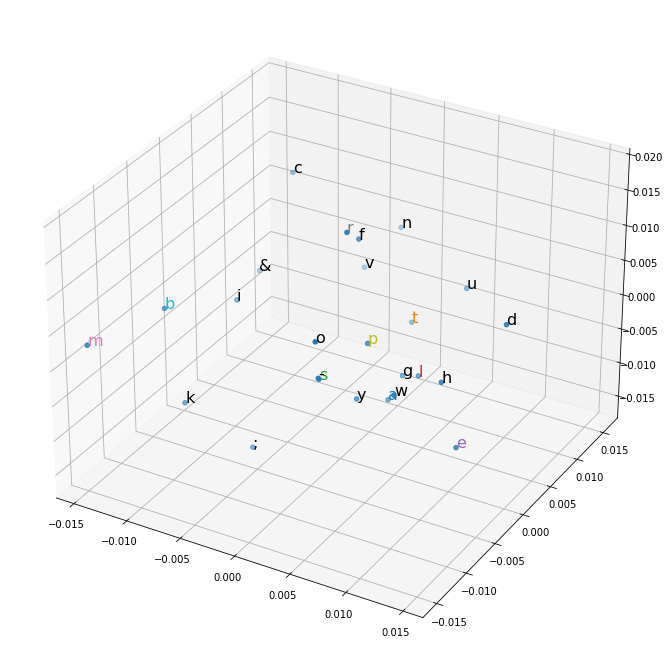

In [29]:
import matplotlib.pyplot as plt
words = list(model.wv.vocab)

plot3D(result, words)